In [1]:
from data_preprocessing import *
import os
import io
import sys
import re
import time
import math
import pickle

import numpy as np
import pandas as pd

from numpy import nan as Nan
from numpy import inf as inf
from tqdm import notebook as tqdm
from scipy.sparse import csr_matrix
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor, Pool, EShapCalcType, EFeaturesSelectionAlgorithm
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostRegressor, Pool, EShapCalcType, EFeaturesSelectionAlgorithm



In [2]:
import pandas as pd
df = pd.read_csv('Kahle2020.predicted_barriers.csv')
df

,src_database,src_id,structure,mobile_id,barrier
0,Crystallography Open Database,1537475,Li24Al8N16,0,10.122589
1,Crystallography Open Database,1537475,Li24Al8N16,1,10.139496
2,Crystallography Open Database,1537475,Li24Al8N16,2,10.142868
3,Crystallography Open Database,1537475,Li24Al8N16,3,10.129608
4,Crystallography Open Database,1537475,Li24Al8N16,4,10.131851
...,...,...,...,...,...
1148,Icsd,416956,Na4Li4B16O28,7,2.778259
1149,Icsd,291512,Na2Li4B2P4O16,2,1.564987
1150,Icsd,291512,Na2Li4B2P4O16,3,1.555054
1151,Icsd,291512,Na2Li4B2P4O16,4,2.649597


In [3]:
def load_csv(path):
    save_path = os.path.join(os.getcwd(), path)
    open_file = open(save_path, 'rb')
    labels_df = pickle.load(open_file)
    open_file.close()
    return labels_df


dfs = []
for i in range(5):
    dfs.append(load_csv(f"groups_and_oxi_states_5_frames/df_features_step_{i}.pkl"))


In [4]:
df_modified = df.groupby(by=["structure", "src_id"]).min().reset_index()
print(len(df_modified))

121


In [5]:
dfs[0]['stru_label'].to_list() == dfs[1]['stru_label'].to_list() == dfs[2]['stru_label'].to_list() == dfs[3]['stru_label'].to_list() == dfs[4]['stru_label'].to_list()

True

In [6]:
for i in range(5):
    dfs[i] = dfs[i].merge(df_modified, left_on=['stru_label', 'stru_id'], right_on=['structure', 'src_id'])
    dfs[i] = dfs[i].drop(['structure',	'src_id', 'src_database', 'mobile_id'],axis=1)

In [7]:
dfs = []
for i in range(5):
    path_to_save = 'groups_and_oxi_states_5_frames/df_features_with_barrier_step_{}.pkl'.format(i)
    dfs.append(load_csv(path_to_save))

In [8]:
from aiida_utils.load_data import load_data_slim
data_slim = load_data_slim()
data_slim[data_slim['temp'] == 1000]
data_slim = data_slim.groupby(by=["stru_label", "stru_id"]).min().reset_index()


/usr/local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_23159/3096521026.py:4: FutureWarning: Dropping invalid columns in DataFrameGroupBy.min is deprecated. In a future version, a TypeError will be raised. Before calling .min, select only columns which should be valid for the function.
  data_slim = data_slim.groupby(by=["stru_label", "stru_id"]).min().reset_index()


In [9]:
data_slim = data_slim.merge(df_modified, left_on=['stru_label', 'stru_id'], right_on=['structure', 'src_id'])
data_slim = data_slim.merge(dfs[0][['stru_label',  'stru_id', 'is_good']], left_on=['stru_label', 'stru_id'], right_on=['stru_label', 'stru_id'])

In [10]:
data_slim

,stru_label,stru_id,stru_db,temp,diff_mean,diff_std,diff_sem,structure,src_id,src_database,mobile_id,barrier,is_good
0,Ba4Li6Nb2N8,75516,Icsd,1000.0,-9.801221e-09,1.486174e-08,1.050883e-08,Ba4Li6Nb2N8,75516,Icsd,4,3.880035,False
1,Ba4Li6Ta2N8,75031,Icsd,1000.0,-2.874040e-08,2.562046e-08,1.811640e-08,Ba4Li6Ta2N8,75031,Icsd,4,3.897186,False
2,Cs2Li6Cl8,245975,Icsd,500.0,6.850619e-08,1.577688e-07,2.326175e-08,Cs2Li6Cl8,245975,Icsd,2,0.414459,True
3,Cs3Li2Br5,245978,Icsd,1000.0,-1.997376e-08,1.882750e-07,1.087006e-07,Cs3Li2Br5,245978,Icsd,3,0.514509,False
4,Cs4Li4B4P8O30,424281,Icsd,1000.0,-9.624829e-10,5.407914e-08,3.823973e-08,Cs4Li4B4P8O30,424281,Icsd,4,2.767853,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,Rb8Li4Ta4S16,1535645,Crystallography Open Database,1000.0,4.959528e-06,7.254926e-06,1.396211e-06,Rb8Li4Ta4S16,1535645,Crystallography Open Database,8,1.265625,True
112,Sr12Li24Si24N48,4002768,Crystallography Open Database,1000.0,-3.019376e-10,1.412826e-08,8.156953e-09,Sr12Li24Si24N48,4002768,Crystallography Open Database,12,6.694336,False
113,Sr2Li4Ta4O14,246277,Icsd,1000.0,-5.855213e-09,1.039611e-08,6.002195e-09,Sr2Li4Ta4O14,246277,Icsd,2,4.163895,False
114,Sr6Li12Ta4O22,4306193,Crystallography Open Database,1000.0,3.019660e-07,5.887853e-07,1.699677e-07,Sr6Li12Ta4O22,4306193,Crystallography Open Database,6,6.037476,False


In [11]:
data_slim = data_slim[['stru_label', 'stru_id', 'stru_db', 'temp', 'diff_mean', 'diff_std',
       'diff_sem', 'is_good', 'barrier']]

In [12]:
import seaborn as sns

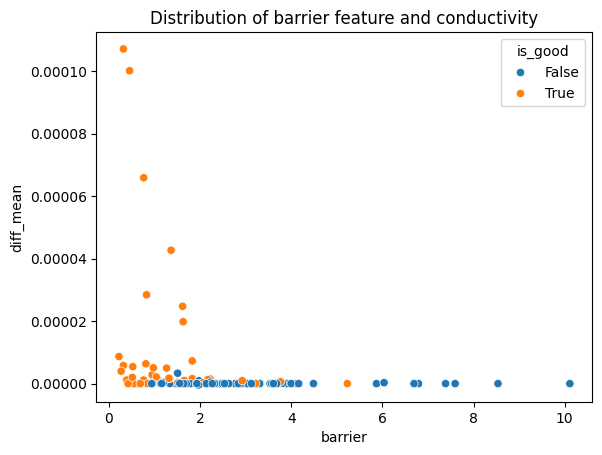

In [13]:
sns.scatterplot(data=data_slim, x="barrier", y="diff_mean", hue = 'is_good')
plt.title('Distribution of barrier feature and conductivity') 
plt.show()

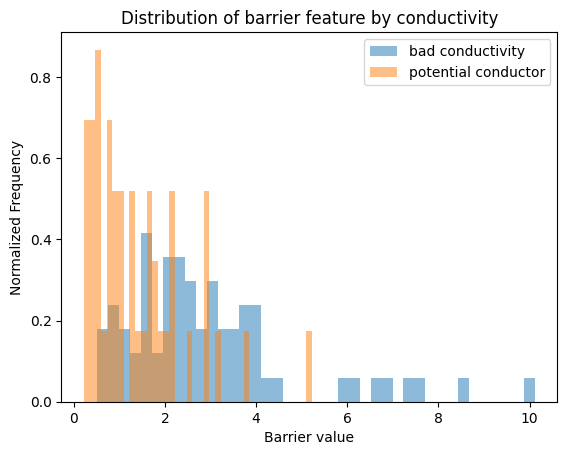

In [14]:
data = dfs[0]
bad_conductors = data[data['is_good'] == True]['barrier']
good_conductors = data[data['is_good'] == False]['barrier']

plt.hist(good_conductors, alpha=0.5, label='bad conductivity', density = True, stacked = True, bins = 40)
plt.hist(bad_conductors, alpha=0.5, label='potential conductor', density = True, stacked = True, bins = 40)

plt.legend(loc='upper right')
plt.title('Distribution of barrier feature by conductivity')
plt.xlabel('Barrier value')
plt.ylabel('Normalized Frequency')
plt.show()

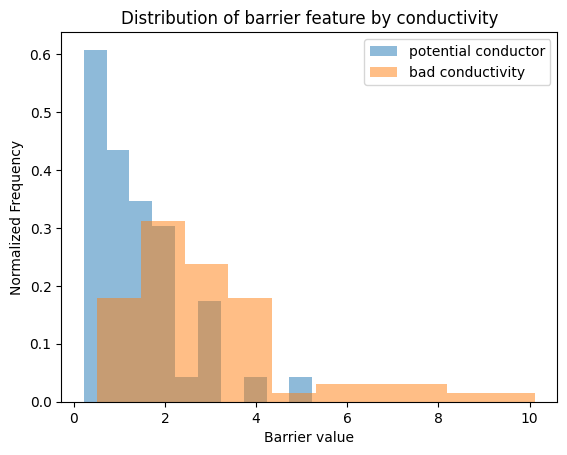

In [15]:
data = dfs[0]
bad_conductors = data[data['is_good'] == True]['barrier']
good_conductors = data[data['is_good'] == False]['barrier']

plt.hist(bad_conductors, alpha=0.5, label='potential conductor', density = True, stacked = True)
plt.hist(good_conductors, alpha=0.5, label='bad conductivity', density = True, stacked = True)
plt.legend(loc='upper right')
plt.title('Distribution of barrier feature by conductivity')
plt.xlabel('Barrier value')
plt.ylabel('Normalized Frequency')
plt.show()

In [16]:
df = dfs[0]
df.rename(columns={'barrier': 903}, inplace = True)
df.drop(['stru_label', 'stru_id'], axis=1, inplace = True)

In [17]:
X, y = (df.drop(['is_good'], axis=1), df['is_good'].astype(int))
scaler = StandardScaler()
X = X.to_numpy()
X_scaled = scaler.fit_transform(X)

In [19]:
from sklearn.model_selection import train_test_split
splits = [8334788, 9151291, 4517925, 5765657, 1797675]
roc_auc = []
for random_split in splits:
    assembled_pred = np.zeros(46)
    X, y = (df.drop(['is_good'], axis=1), df['is_good'].astype(int))
    X = X.to_numpy()
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_tr, X_te, y_tr, y_te = train_test_split(X_scaled, y, test_size=0.4, random_state=random_split)
    model = CatBoostClassifier(eval_metric='AUC', verbose = False)
    feature_names = ['F{}'.format(i) for i in range(np.array(X_tr).shape[1])]
    test_pool = Pool(np.array(X_te), y_te, feature_names=feature_names)
    summary = model.select_features(
        X = X_tr,
        y=y_tr,
        eval_set=test_pool,
        features_for_select= np.arange(len(X_tr[0])),
        num_features_to_select=50,
        steps=6,
        algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
        shap_calc_type=EShapCalcType.Regular,
        train_final_model=True,
        logging_level='Silent',
        plot=False)
    y_pred = model.predict_proba(X_te)[:, 1]
    roc_auc.append(roc_auc_score(y_te, y_pred))
    print(f"roc auc score {roc_auc[-1]} for random_split {random_split}")
print(f"mean roc auc {np.mean(roc_auc)}")

roc auc score 0.9248120300751879 for random_split 8334788
roc auc score 0.9133064516129032 for random_split 9151291
roc auc score 0.8113553113553112 for random_split 4517925
roc auc score 0.8509803921568627 for random_split 5765657
roc auc score 0.9745098039215686 for random_split 1797675
mean roc auc 0.8949927978243668


In [28]:
X, y = (df.drop(['is_good', 903], axis=1), df['is_good'].astype(int))
scaler = StandardScaler()
X = X.to_numpy()
X_scaled = scaler.fit_transform(X)

In [29]:
from sklearn.model_selection import train_test_split
splits = [8334788, 9151291, 4517925, 5765657, 1797675]
roc_auc = []
for random_split in splits:
    assembled_pred = np.zeros(46)
    X, y = (df.drop(['is_good'], axis=1), df['is_good'].astype(int))
    X = X.to_numpy()
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_tr, X_te, y_tr, y_te = train_test_split(X_scaled, y, test_size=0.4, random_state=random_split)
    model = CatBoostClassifier(eval_metric='AUC', verbose = False)
    feature_names = ['F{}'.format(i) for i in range(np.array(X_tr).shape[1])]
    test_pool = Pool(np.array(X_te), y_te, feature_names=feature_names)
    summary = model.select_features(
        X = X_tr,
        y=y_tr,
        eval_set=test_pool,
        features_for_select= np.arange(len(X_tr[0])),
        num_features_to_select=50,
        steps=6,
        algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
        shap_calc_type=EShapCalcType.Regular,
        train_final_model=True,
        logging_level='Silent',
        plot=False)
    y_pred = model.predict_proba(X_te)[:, 1]
    roc_auc.append(roc_auc_score(y_te, y_pred))
    print(f"roc auc score {roc_auc[-1]} for random_split {random_split}")
print(f"mean roc auc {np.mean(roc_auc)}")

roc auc score 0.9248120300751879 for random_split 8334788
roc auc score 0.9133064516129032 for random_split 9151291
roc auc score 0.8113553113553112 for random_split 4517925
roc auc score 0.8509803921568627 for random_split 5765657
roc auc score 0.9745098039215686 for random_split 1797675
mean roc auc 0.8949927978243668


In [30]:
X, y = (df[[903]], df['is_good'].astype(int))
scaler = StandardScaler()
X = X.to_numpy()
X_scaled = scaler.fit_transform(X)

In [ ]:
df.shape

In [35]:
from sklearn.model_selection import train_test_split
splits = [8334788, 9151291, 4517925, 5765657, 1797675]
roc_auc = []
for random_split in splits:
    assembled_pred = np.zeros(46)
    X, y = (df.drop(['is_good'], axis=1), df['is_good'].astype(int))
    X = X.to_numpy()
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_tr, X_te, y_tr, y_te = train_test_split(X_scaled, y, test_size=0.4, random_state=random_split)
    model = CatBoostClassifier(eval_metric='AUC', verbose = False)
    feature_names = ['F{}'.format(i) for i in range(np.array(X_tr).shape[1])]
    test_pool = Pool(np.array(X_te), y_te, feature_names=feature_names)
    # summary = model.select_features(
    #     X = X_tr,
    #     y=y_tr,
    #     eval_set=test_pool,
    #     features_for_select= np.arange(len(X_tr[0])),
    #     num_features_to_select=50,
    #     steps=6,
    #     algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    #     shap_calc_type=EShapCalcType.Regular,
    #     train_final_model=True,
    #     logging_level='Silent',
    #     plot=False)
    model.fit(X_tr, y_tr)
    print(f'train roc-auc: {roc_auc_score(y_tr, model.predict_proba(X_tr)[:, 1])}')
    y_pred = model.predict_proba(X_te)[:, 1]
    roc_auc.append(roc_auc_score(y_te, y_pred))
    print(f"roc auc score {roc_auc[-1]} for random_split {random_split}")
print(f"mean roc auc {np.mean(roc_auc)}")

train roc-auc: 1.0
roc auc score 0.693609022556391 for random_split 8334788
train roc-auc: 1.0
roc auc score 0.7600806451612905 for random_split 9151291
train roc-auc: 1.0
roc auc score 0.7234432234432234 for random_split 4517925
train roc-auc: 1.0
roc auc score 0.7176470588235294 for random_split 5765657
train roc-auc: 1.0
roc auc score 0.8529411764705882 for random_split 1797675
mean roc auc 0.7495442252910045
